In [1]:
# import lsst.summit.extras

In [2]:
# lsst.summit.__file__

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from lsst.summit.extras.plotting.psfPlotting import makeAzElPlot, makeTableFromSourceCatalogs,makeFocalPlanePlot, makeEquatorialPlot, addColorbarToAxes
from atmospheric_dispersion_correction import addADC_to_Table
from lsst.obs.lsst import LsstComCam, LsstCam
import matplotlib.pyplot as plt
from ellipticity_util import addFieldCoords_to_Table, makeOCSPlot, read_batoid_table, addOpticalCoords_to_Table, MakeGridMedianPSF, makeTableFromCalexps
# from lsst.ts.aos.analysis import StateFetcher #source .user_setups
from lsst.daf.butler import Butler
import numpy as np
from astropy.table import Table

In [14]:
folderout = '/home/v/vittorio/image_quality_shared/imsim/ellipticitymap/figures/'

## set up

In [15]:
selection_index = 1 # 0 for ComCam; 1 for Imsim LSSTCam

if selection_index == 0:
    #ComCam
    camera = LsstComCam().getCamera()
    first_det = 0
    n_det = 9
    butler = Butler(
        "embargo", 
        collections=["LSSTComCam/nightlyValidation"], 
        instrument="LSSTComCam"
    )
    
    dayObs = 20241115 
    seqNum = 92
    visit_id = int(f"{dayObs}{seqNum:05d}")
    suffix_out = 'nightlyValidation'

elif selection_index == 1:
    #Imsim LSSTCam
    camera = LsstCam().getCamera()
    first_det = 94
    n_det = 1 # LSSTCam
    import sys
    sys.path.append("/sdf/data/rubin/shared/image_quality/imsim/notebooks/") #file with convertion between seqnum and collection
    from collection_dictionary_shared import collection_dictionary
    folder = '/sdf/data/rubin/shared/image_quality/imsim/'
    ############Define the butler data configuration and collection (una tantum )
    config = folder+'repo'
    collection_dict = collection_dictionary()
    seqNum = 218
    
    if seqNum >= 188:
        seqnum_base = 7023071700000
    else:
        seqnum_base = 5023071800000
    
    visit_id = seqNum+seqnum_base
    collections = collection_dict[visit_id]
    butler = Butler(config, collections=collections)
    suffix_out = 'ImSim'

## Lettura icSrc

In [16]:
icSrcs={}
for i in range(n_det):
    try:
        icSrcs[first_det+i] = butler.get("icSrc", dataId={"visit":visit_id, "detector":first_det+i})
        print(first_det+i)
    except:
        continue
visitInfo = butler.get("postISRCCD.visitInfo", dataId={"exposure":visit_id, "detector":(first_det+n_det-1)})

94


In [17]:
table = makeTableFromSourceCatalogs(icSrcs, visitInfo)

In [18]:
visitInfo

VisitInfo(exposureTime=30, darkTime=30, date=2023-07-18T10:07:03.614199910, UT1=nan, ERA=1.52321 rad, boresightRaDec=(60.4904550264, -38.1643749590), boresightAzAlt=(114.3857481820, +80.0000000000), boresightAirmass=1.0148, boresightRotAngle=2.41925 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(nan, nan, nan), instrumentLabel='LSSTCam', id=7023071700218, focusZ=0, observationType='science', scienceProgram='398414', observationReason='survey', object='UNKNOWN', hasSimulatedContent=true)

In [19]:
# add atmospheric dispersion correction to the table
# table = addADC_to_Table( table, elevation_angle, filter, pressure=800, temperature=15 )
# TODO: check if the default values are sensible

band = butler.get("postISRCCD", dataId={"exposure":visit_id, "detector":first_det+n_det-1}).getFilter().bandLabel
elevation_angle = visitInfo.boresightAzAlt[1].asDegrees() # elevation angle in degrees
table = addADC_to_Table( table, elevation_angle, band ) # optional pressure and temperature arguments

In [20]:
table = addOpticalCoords_to_Table( table )
table = addFieldCoords_to_Table( table, camera ) #non mi funziona quando uso immagini imsim

In [21]:
table_grid = MakeGridMedianPSF(table, 12, 12, 3)

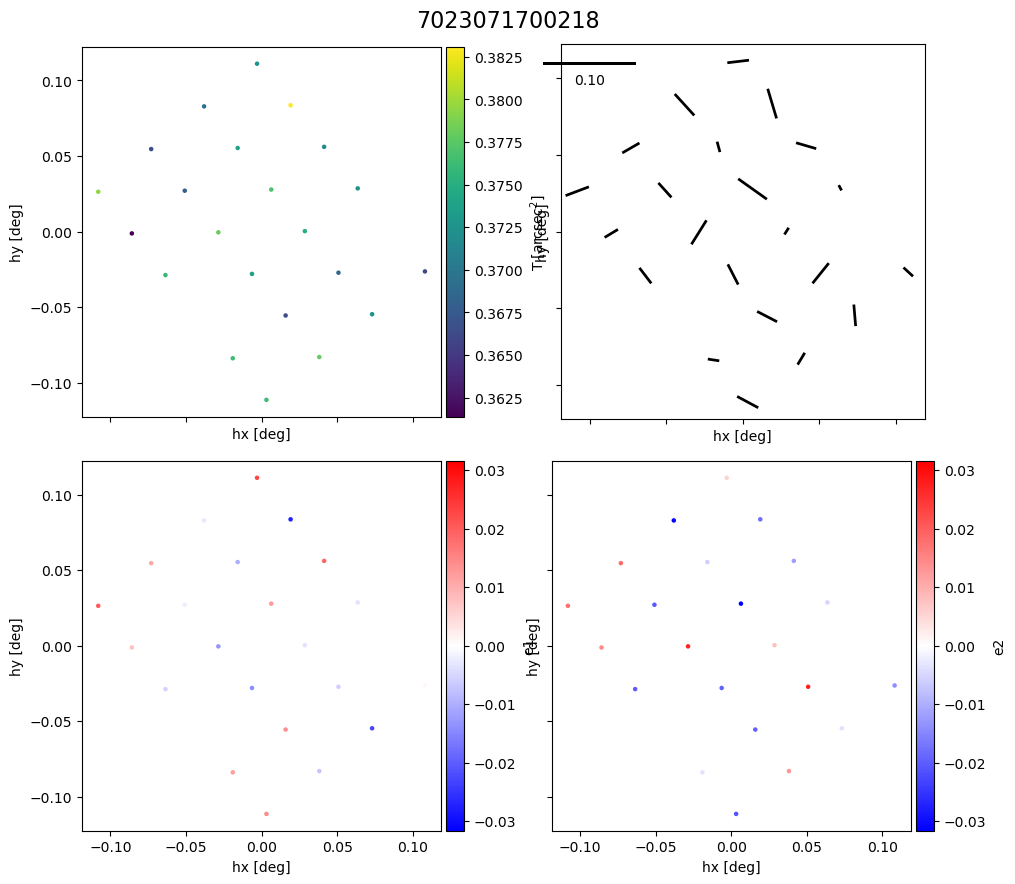

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
fig.suptitle(visit_id, fontsize=16)
makeOCSPlot(fig, axes, table, camera, autoscale=True, scale_quiver=.75)
plt.show()
fig.savefig(folderout+'Ellipticitymap_OCS_'+suffix_out+'_'+str(visit_id)+'.pdf')

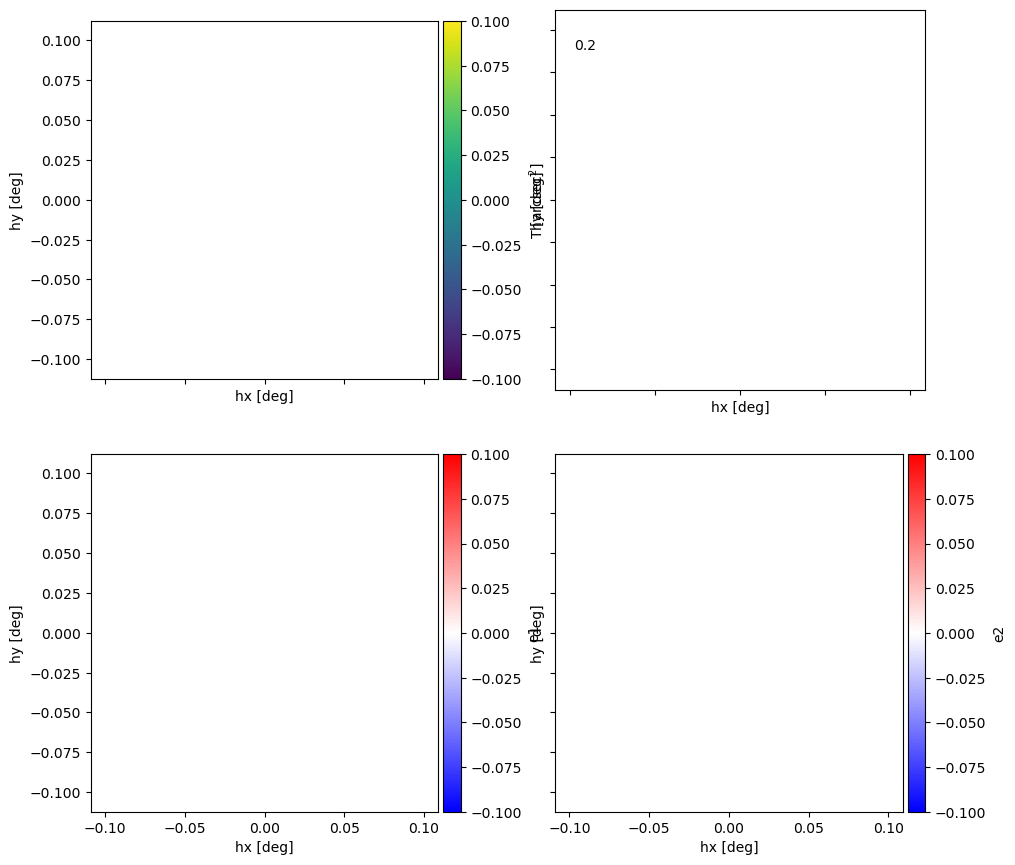

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
makeOCSPlot(fig, axes, table_grid, camera)
plt.show()
fig.savefig(folderout+'Ellipticitymap_grid_OCS_'+suffix_out+'_'+str(visit_id)+'.pdf')

## Lettura Calexp

In [13]:
calexps = {}
psfs = {}
dets = {}
bkgds = {}
calexp_infos = {}
sourcess = {}
for i in range(n_det):
    try:
        dataId = {'visit': visit_id, 'detector': i}
        calexp = butler.get('calexp', **dataId)
        sources = butler.get('src', dataId)
        psf = calexp.getPsf()
        det = calexp.getDetector()
        bkgd = butler.get('calexpBackground', **dataId)
        calexp_infos.append(calexp.getInfo())

        calexps.append(calexp)
        psfs.append(psf)
        dets.append(det)
        bkgds.append(bkgd)
        sourcess.append(sources)

    except:
        continue
visitInfo = butler.get("postISRCCD.visitInfo", dataId={"exposure":visit_id, "detector":(n_det-1)})

DatasetNotFoundError: Dataset postISRCCD.visitInfo with data ID {instrument: 'LSSTCam', detector: 0, exposure: 7023071700215} could not be found in collections ('pipetask_output/20250611T110726Z',).

In [ ]:
makeTableFromCalexps(calexps, sourcess, psfs, elevation_angle, visitInfo)

In [14]:
table.columns

<TableColumns names=('id','coord_ra','coord_dec','parent','calib_psf_candidate','calib_psf_used','calib_psf_reserved','base_SdssCentroid_x','slot_Centroid_x','base_SdssCentroid_y','slot_Centroid_y','base_SdssCentroid_xErr','slot_Centroid_xErr','base_SdssCentroid_yErr','slot_Centroid_yErr','base_SdssCentroid_flag','base_CircularApertureFlux_flag_badCentroid','base_GaussianFlux_flag_badCentroid','base_PsfFlux_flag_badCentroid','ext_shapeHSM_HsmSourceMoments_flag_badCentroid','slot_Centroid_flag','base_SdssCentroid_flag_edge','base_CircularApertureFlux_flag_badCentroid_edge','base_GaussianFlux_flag_badCentroid_edge','base_PsfFlux_flag_badCentroid_edge','ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge','slot_Centroid_flag_edge','base_SdssCentroid_flag_noSecondDerivative','base_CircularApertureFlux_flag_badCentroid_noSecondDerivative','base_GaussianFlux_flag_badCentroid_noSecondDerivative','base_PsfFlux_flag_badCentroid_noSecondDerivative','ext_shapeHSM_HsmSourceMoments_flag_badCentroid

## alt/az in mm

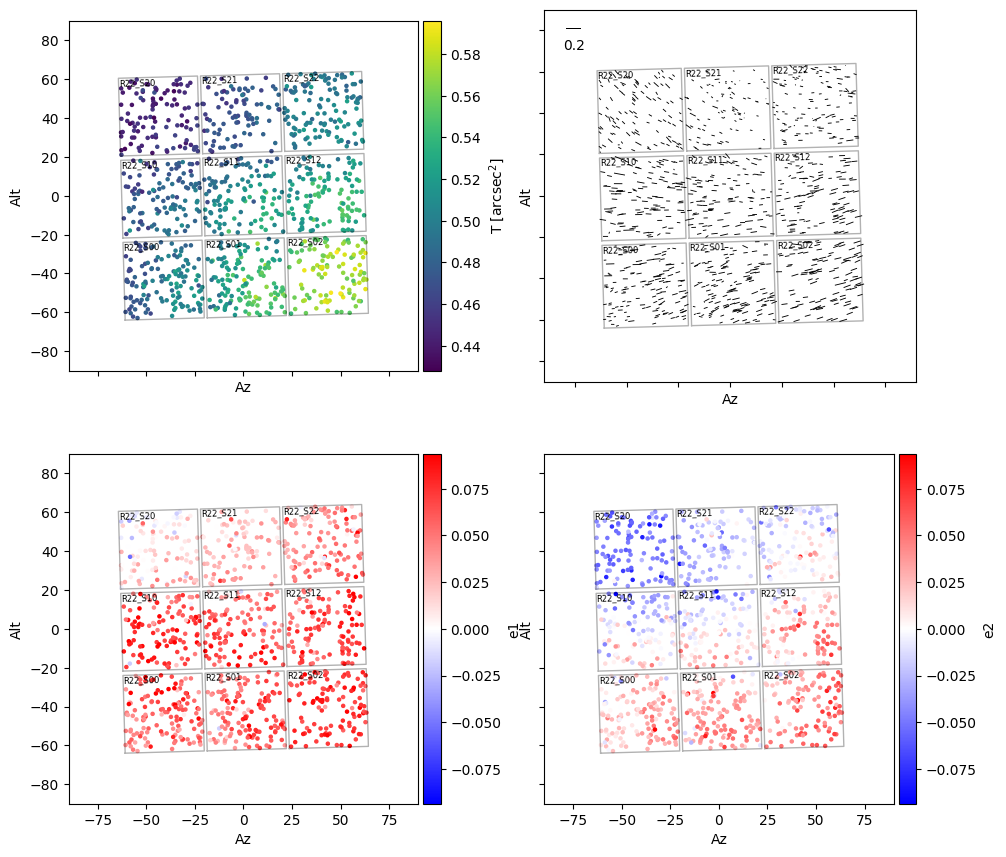

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
makeAzElPlot(fig, axes, table, camera)
plt.show()

In [21]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
# makeFocalPlanePlot(fig, axes, table, camera)
# plt.show()

In [22]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
# makeEquatorialPlot(fig, axes, table, camera)
# plt.show()

#write output file

In [23]:
import numpy as np

In [22]:
from astropy.io import ascii

In [19]:
outname = 'prova.csv'
# outname = '/home/r/rzanmar/coords_seq%.8d.csv'%seqnum

In [24]:
outname

'prova.csv'

In [25]:
ascii.write(table[ 'oc_x','oc_y','oc_Ixx','oc_Iyy','oc_Ixy', ],outname, format='csv', fast_writer=False, overwrite=True)

In [26]:
table.meta['ocRot']

array([[ 0.99960987, -0.02793032],
       [-0.02793032, -0.99960987]])

# verify mm to field [deg] conversion

In [27]:
hx, hy = table['x'] * 0.2 / 36, table['y'] * 0.2 / 36      # 0.2 arcsec / pix * pix / 10um -> 0.2/36 deg/mm

In [28]:
hx_rot, hy_rot = table['oc_x'] * 0.2 / 36, table['oc_y'] * 0.2 / 36

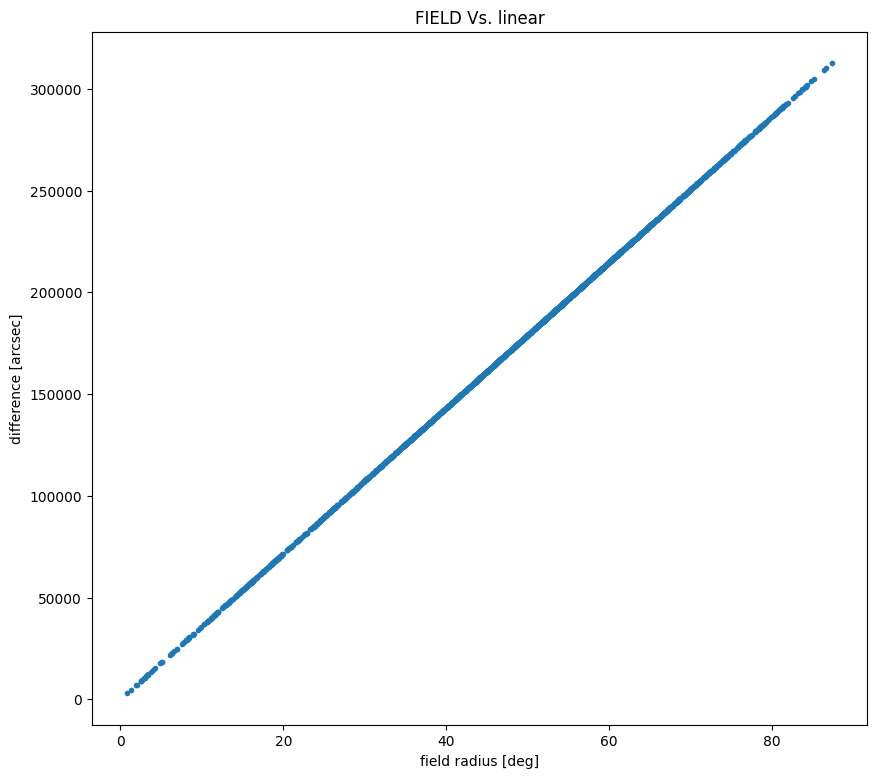

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 9), sharex=True, sharey=True)
plt.plot( np.sqrt( table['oc_x']**2+table['oc_y']**2), np.sqrt( (table['oc_x'] - hx_rot)**2 + (table['oc_y'] - hy_rot)**2)*3600, '.' )
axes.set_xlabel('field radius [deg]')
axes.set_ylabel('difference [arcsec]')
axes.set_title('FIELD Vs. linear')
plt.show()

In [30]:
table.meta['aaRot']

array([[ 0.99960987, -0.02793032],
       [ 0.02793032,  0.99960987]])

In [31]:
table.meta['ocRot']

array([[ 0.99960987, -0.02793032],
       [-0.02793032, -0.99960987]])